In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import math
import copy

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
torch.__version__

'1.10.2+cu102'

In [4]:
## 1. Embedding

class Word_Embedding(nn.Module):
    def __init__(self,vocab,d_model):
        super(Embedding,self).__init__()
        self.embedding=nn.Embedding(len(vocab),d_model)
        self.vocab=vocab
        self.d_model=d_model
    
    def forward(self,x):
        output=self.embedding(x)*math.sqrt(self.d_model)
        return output
    

In [5]:
## 2. Positional-Encoding (dropout 적용)

class PositionalEncoding(nn.Module):
    def __init__(self,position,d_model,dropout_rate):
        super(PositionalEncoding,self).__init__()
        self.pos_encoding=self.positional_encoding(position,d_model)
        self.dropout=nn.Dropout(dropout_rate)
        
    def get_angles(self,position,i,d_model):
                
        angles=1/np.power(10000,(2*(i//2))/torch.tensor(d_model,dtype=torch.float32))

        return position * angles
    
    def positional_encoding(self,position,d_model):
        
        position_tensor=torch.arange(position,dtype=torch.float32)
        
        index_i=torch.arange(d_model,dtype=torch.float32)
        
        angle_rads=self.get_angles(position=position_tensor.unsqueeze(1),i=index_i.unsqueeze(0),d_model=d_model)
        
        ## 배열의 짝수에는 사인함수 적용
        sines=torch.sin(angle_rads[:,0::2])
        
        ## 홀수에는 코사인 함수
        cosines=torch.cos(angle_rads[:,1::2])
        
        angle_rads=np.zeros(angle_rads.shape)
        angle_rads[:,0::2]=sines
        angle_rads[:,1::2]=cosines
        
        pos_encoding=torch.tensor(angle_rads,dtype=torch.float32)
        pos_encoding=pos_encoding.unsqueeze(0)
        
        print(pos_encoding.size())
        return pos_encoding
    
    def forward(self,inputs):
        output=inputs+self.pos_encoding[:,inputs.size(1),:] ## positional-encoding
        output=self.dropout(output) ## dropout 적용 
        return output
        
        

In [6]:
class TransformerEmbedding(nn.Module):
    def __init__(self,embedding,positional_encoding):
        super(TransformerEmbedding,self).__init__()
        self.embedding=nn.Sequential(embedding,positional_encoding)
        
    def forward(self,x):
        output=self.embedding(x)
        return output

torch.Size([1, 50, 128])


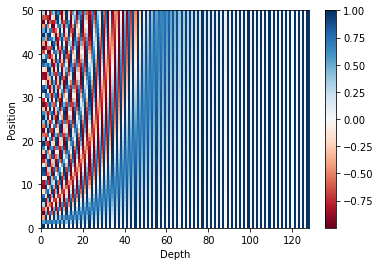

In [7]:
## sample 50개 단어, 128 model dimension ## 

sample_pos_encoding=PositionalEncoding(50,128,0.2)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0],cmap='RdBu')

plt.xlabel('Depth')
plt.xlim((0,128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [8]:
def scaled_dot_product_attention(query,key,value,mask):
    
    ## attention score
    trans_k=key.transpose(0,1)
    matrix_qk=torch.matmul(query,trans_k)
    
    ## scaling
    depth=torch.tensor(key.shape[-1],dtype=torch.float32)
    scaled_dot=matrix_qk/torch.sqrt(depth)
    
    ## masking
    if mask is not None:
        scaled_dot+=(mask*-1e9)
    
    ## key의 문장 길이 방향으로 softmax
    attention_weights=F.softmax(scaled_dot,dim=3)
    
    ## output --> (batch_size,num_heads,query문장길이,dmodel/num_heads)
    output=torch.matmul(attention_weights,value)
    
    return output,attention_weights
    

In [9]:
## Encoder의 첫번째 서브층 (멀티-헤드 어텐션)

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,num_heads,name="multi_head_attention"):
        super(MultiHeadAttention,self).__init__(name=name)
        
        self.q_dim=0
        self.k_dim=0
        self.v_dim=0
        self.last_dim=0
        
        self.num_heads=num_heads
        self.d_model=d_model # 전체 모델의 차원
        
        assert d_model%self.num_heads==0
        
        # d_model / num_heads (논문:64)
        self.depth=d_model//self.num_heads
        
        # WQ, WK, WV 에 해당하는 layer
        self.query_dense=nn.Linear(self.q_dim,d_model)
        self.key_dense=nn.Linear(self.k_dim,d_model)
        self.value_dense=nn.Linear(self.v_dim,d_model)
        
        ## WO layer
        self.dense=nn.Linear(self.last_dim,d_model)
    
    ## split
    def split_heads(self,inputs,batch_size):
        inputs=torch.reshape(inputs,(batch_size,-1,self.num_heads,self.depth))
        return inputs.permute(0,2,1,3) # batch_size,self.num_heads,qkv,self.depth
    
    def forward(self,inputs):
        query,key,value,mask=inputs['query'],inputs['key'],inputs['value'],inputs['mask']
        batch_size=query.shape[0]
        
        ## hmm 이게 맞나
        self.q_dim=query
        self.k_dim=key
        self.v_dim=value
        
        query=self.query_dense(query)
        key=self.key_dense(key)
        value=self.value_dense(value)
        
        ## head_split
        query=self.split_heads(query,batch_size)
        key=self.split_heads(key,batch_size)
        value=self.split_heads(value,batch_size)
        
        ## scaled_dot product attention
        scaled_attention,_=scaled_dot_product_attention(query,key,value,mask)
        
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention=scaled_attention.permute(0,2,1,3)
        
        ## concatenate --> (batch_size, query의 문장 길이, d_model) (차원축소)
        concat_attention=scaled_attention.reshape(batch_size,-1,self.d_model)
        
        ## W0 layer
        ## batch_size,query 문장 길이, d_model
        outputs=self.dense(concat_attention)
        
        return outputs

In [10]:
## Encoder의 첫번째 서브층 (멀티-헤드 어텐션)

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,num_heads,qkv_fc_layer,fc_layer,dropout_rate):
        super(MultiHeadAttention,self).__init__()
        
        self.num_heads=num_heads
        self.d_model=d_model # 전체 모델의 차원
        
        assert d_model%self.num_heads==0
        
        # d_model / num_heads (논문:64)
        self.depth=d_model//self.num_heads
        
        # WQ, WK, WV 에 해당하는 layer
        self.query_fc=copy.deepcopy(qkv_fc_layer) # (d_model,d_q)
        self.key_fc=copy.deepcopy(qkv_fc_layer) # (d_model,d_k)
        self.value_fc=copy.deepcopy(qkv_fc_layer) # (d_model,d_v)

        ## WO layer
        self.fc_layer=fc_layer
    
    ## split head
    def split_heads(self,inputs,batch_size):
        inputs=torch.reshape(inputs,(batch_size,-1,self.num_heads,self.depth))
        return inputs.permute(0,2,1,3) # batch_size,self.num_heads,qkv,self.depth
    
    def forward(self,inputs):
        
        query,key,value,mask=inputs['query'],inputs['key'],inputs['value'],inputs['mask']
        batch_size=query.shape[0]

        
        query=self.query_fc(query)
        key=self.key_fc(key)
        value=self.value_fc(value)
        
        ## head_split
        query=self.split_heads(query,batch_size)
        key=self.split_heads(key,batch_size)
        value=self.split_heads(value,batch_size)
        
        ## scaled_dot product attention
        scaled_attention,_=scaled_dot_product_attention(query,key,value,mask)
        
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention=scaled_attention.permute(0,2,1,3)
        
        ## concatenate --> (batch_size, query의 문장 길이, d_model) (차원축소)
        concat_attention=scaled_attention.reshape(batch_size,-1,self.d_model)
        
        ## W0 layer
        ## batch_size,query 문장 길이, d_model
        outputs=self.fc_layer(concat_attention)
        
        return outputs


In [9]:
### padding mask 사용법 

def create_padding_mask(x):
    # mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    mask=(x>=0).type(torch.int32).unsqueeze(1).unsqueeze(1)
    return mask

In [ ]:
def encoder_layer(dff,d_model,num_heads,dropout,name="encoder_layer"):
    
    input_tensor=torch.randn(None,d_model)
    
    # padding mask
    padding_mask=torch.randn(1,1,None)
    
    ## Multi-Head Attention (encoder first sublayer)
    # d_model,num_heads,name="multi_head_attention"):
    attention=MultiHeadAttention(d_model,num_heads)({
        'query':inputs,'key':inputs,'value':inputs,'mask':padding_mask
    })
    
    ## dropout + residual & layer normalization
    